# Span Batch Analysis

## Initialization

Every data obtained for analysis is gained by randomly selecting L1 span(20000 L1 blocks).

In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import random

DATA_ROOT_DIR = "./artifacts"

In [2]:
#### FIX ME ####
l1_chain_name = "mainnet"
l2_chain_name = "pgn"
################

CHAIN_NAME = f"{l1_chain_name}/{l2_chain_name}"
DATA_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}"

In [3]:
CHANNEL_CACHE_DIR = f"{DATA_DIR}/channel_cache"
SPAN_BATCH_CACHE_V0_DIR = f"{DATA_DIR}/span_batch_cache_v0"
SPAN_BATCH_CACHE_V1_DIR = f"{DATA_DIR}/span_batch_cache_v1"
SPAN_BATCH_CACHE_V2_DIR = f"{DATA_DIR}/span_batch_cache_v2"
SPAN_BATCH_CACHE_DIRS = [SPAN_BATCH_CACHE_V0_DIR, SPAN_BATCH_CACHE_V1_DIR, SPAN_BATCH_CACHE_V2_DIR]

RESULT_V0_DIR = f"{DATA_DIR}/result_v0"
RESULT_V1_DIR = f"{DATA_DIR}/result_v1"
RESULT_V2_DIR = f"{DATA_DIR}/result_v2"
RESULT_DIRS = [RESULT_V0_DIR, RESULT_V1_DIR, RESULT_V2_DIR]

ACC_L2_START_NUM = !yq eval ".acc_l2_start_number" "span-batch-analysis/config/{l1_chain_name}/{l2_chain_name}.yaml"
ACC_L2_START_NUM = int(ACC_L2_START_NUM[0])
ACC_L2_END_NUM = !yq eval ".acc_l2_end_number" "span-batch-analysis/config/{l1_chain_name}/{l2_chain_name}.yaml"
ACC_L2_END_NUM = int(ACC_L2_END_NUM[0])


In [4]:
TARGET_DIR = RESULT_V2_DIR

Get number of channels and each channel names. Channel name must have length 32 in hexadecimal form.

In [5]:
def is_hexadecimal(s: str) -> bool:
    hex_pattern = re.compile(r'^[a-fA-F0-9]+$')
    return bool(hex_pattern.match(s))


def read_channel_ids(directory):
    channel_ids = set()
    with os.scandir(directory) as entries:
        for entry in entries:
            assert entry.is_file()
            filename = entry.name
            channel_id, ext = os.path.splitext(filename)
            assert ext == ".json" and len(channel_id) == 32 and is_hexadecimal(channel_id)
            channel_ids.add(channel_id)
    return channel_ids


def not_ready_channel_ids(channel_ids):
    not_ready = []
    for channel_id in channel_ids:
          filename = f"{CHANNEL_CACHE_DIR}/{channel_id}.json"
          with open(filename) as f:
              result = json.load(f)
              if not result["is_ready"]:
                  not_ready.append(channel_id)
    return not_ready


channel_ids = read_channel_ids(CHANNEL_CACHE_DIR)
not_ready = not_ready_channel_ids(channel_ids)

channel_ids = list(set(channel_ids) - set(not_ready))

channel_id_count = len(channel_ids)
print(f"Number of channels: {channel_id_count}")

Number of channels: 408


Sanity check of results. Number of jsons in each result directory must be equal to number of (ready) channels.

In [6]:
for directory in SPAN_BATCH_CACHE_DIRS:
    temp_channel_ids = read_channel_ids(directory) 
    assert set(temp_channel_ids) == set(channel_ids), (len(temp_channel_ids), len(channel_ids))

## `UncompressedSizeReductionPercent - SpanBatchMetadataSizePercent` Plot

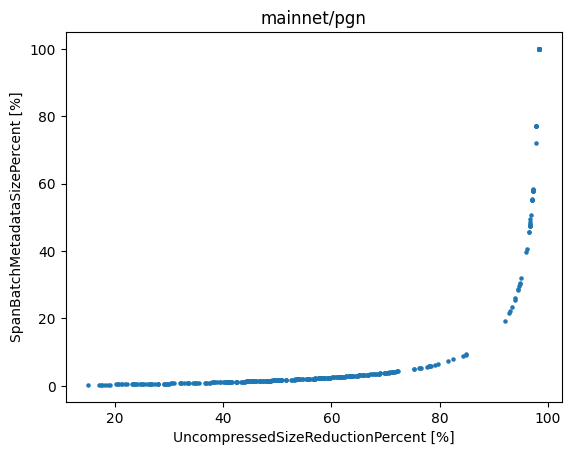

In [7]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Xs.append(uncompressed_reduction_precent)
            metadata_size = result["SpanBatchMetadataSize"]
            tx_size = result["SpanBatchTxSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("UncompressedSizeReductionPercent [%]")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `txs`: size of encoded L2 transactions.
- `SpanBatchMetadataSize`: size of encoded span batch except `txs` field.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `SpanBatchMetadataSizePercent`: `100 * SpanBatchMetadataSize / SpanBatchUncompressedSize`
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`

Plot:
- X axis: `UncompressedSizeReductionPercent`
- Y axis: `SpanBatchMetadataSizePercent`

Analysis:

`UncompressedSizeReductionPercent` and `SpanBatchMetadataSizePercent` are proportional.
- If `SpanBatchMetadataSizePercent` is large, it means `txs` size is less.
- If span batch encoding is effective, `UncompressedSizeReductionPercent` will be large.

Span batch is more effective when there are less txs in it. Its because span batch focus on reducing redundant metadata from consecutive singular batches.


## `CompressedReductionPercent - SpanBatchMetadataSizePercent` Plot

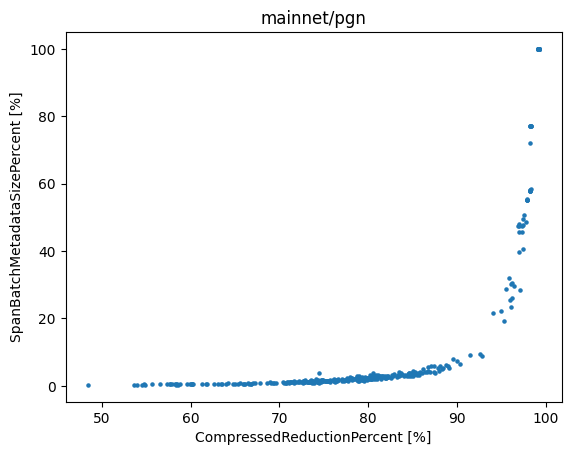

In [8]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            compressed_reduction_precent = result["CompressedReductionPercent"]
            Xs.append(compressed_reduction_precent)
            metadata_size = result["SpanBatchMetadataSize"]
            tx_size = result["SpanBatchTxSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("CompressedReductionPercent [%]")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `txs`: size of encoded L2 transactions.
- `SpanBatchMetadataSize`: size of encoded span batch except `txs` field.
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `SpanBatchMetadataSizePercent`: `100 * SpanBatchMetadataSize / SpanBatchUncompressedSize`
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`

Plot:
- X axis: `CompressedReductionPercent`
- Y axis: `SpanBatchMetadataSizePercent`

Analysis:

`CompressedReductionPercent` and `SpanBatchMetadataSizePercent` are proportional.
- If `SpanBatchMetadataSizePercent` is large, it means `txs` size is less.
- If span batch encoding is effective, `CompressedReductionPercent` will be large.

Span batch is more effective when there are less txs in it. Its because span batch encoding focuses on reducing redundant metadata from consecutive singular batches. The relation is consistent when we analyze using uncompressed size.

By comparing the results with `UncompressedSizeReductionPercent - SpanBatchMetadataSizePercent` Plot, the plot is shifted to the right. This means reduction percentage is better when compression, leading that span batch encoding is more compression friendly. The direct comparison for the effectiveness of compression will be shown at `L2StartNum - (BatchV1sCompressionRatio, SpanBatchCompressionRatio)` Plot.


## `L2StartNum - UncompressedSizeReductionPercent` Plot

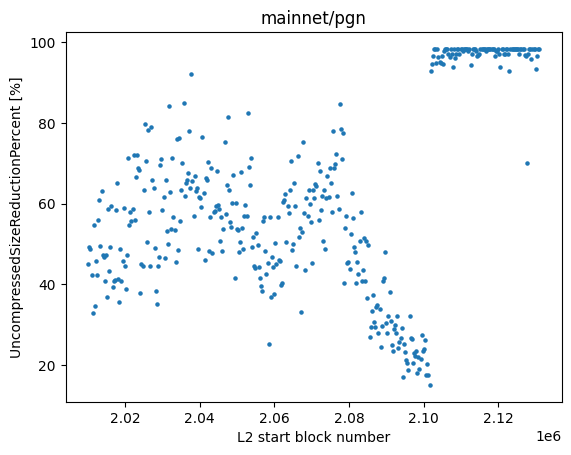

In [9]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)
            
plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 start block number")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()


Definition:
- `L2StartNum`: smallest l2 block number which is included at span batch / singular batches
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`
- `txs`: size of encoded L2 transactions.

Plot:
- X axis: `L2StartNum`
- Y axis: `UncompressedSizeReductionPercent`

Analysis:

The plot shows the time series of `UncompressedSizeReductionPercent` because x axis corresponds to `L2StartNum`. The graph fluctuates, mirroring the effect of chain congestion deviation. Spikes indicate that `txs` size ratio were lesser than neighboring timestamps.

## `L2StartNum - CompressedReductionPercent` Plot

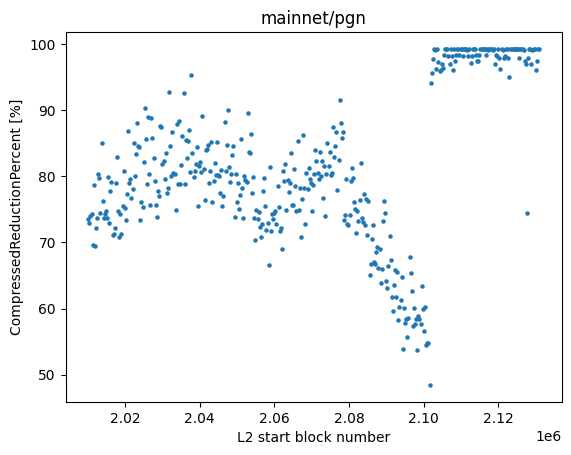

In [10]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            compressed_reduction_precent = result["CompressedReductionPercent"]
            Ys.append(compressed_reduction_precent)
            
plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 start block number")
plt.ylabel("CompressedReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()


Definition:
- `L2StartNum`: smallest l2 block number which is included at span batch / singular batches
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`
- `txs`: size of encoded L2 transactions.

Plot:
- X axis: `L2StartNum`
- Y axis: `CompressedReductionPercent`

Analysis:

The plot shows the time series of `CompressedReductionPercent` because x axis corresponds to `L2StartNum`. The graph fluctuates, mirroring the effect of chain congestion deviation. Spikes indicate that `txs` size ratio were lesser than neighboring timestamps.

By comparing the results with `L2StartNum - UncompressedSizeReductionPercent` Plot, the plot is shifted upwards. This means reduction percentage is better when compression, leading that span batch encoding is more compression friendly. The direct comparison for the effectiveness of compression will be shown at `L2StartNum - (BatchV1sCompressionRatio, SpanBatchCompressionRatio)` Plot.


## `L2StartNum - SpanBatchMetadataSizePercent` Plot

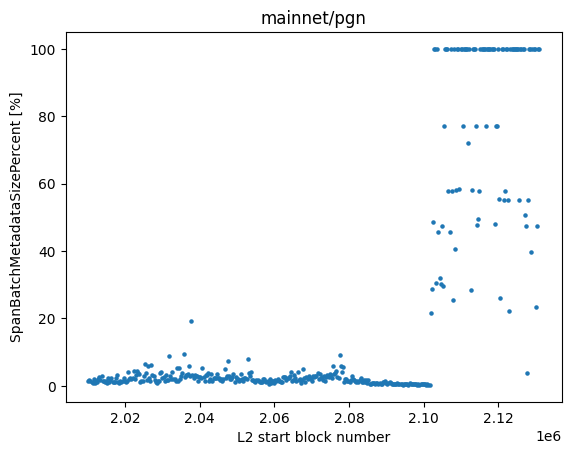

In [11]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            tx_size = result["SpanBatchTxSize"]
            metadata_size = result["SpanBatchMetadataSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 start block number")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `L2StartNum`: smallest l2 block number which is included at span batch / singular batches
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `SpanBatchMetadataSize`: size of encoded span batch except `txs` field.
- `SpanBatchMetadataSizePercent`: `100 * SpanBatchMetadataSize / SpanBatchUncompressedSize`

Plot:
- X axis: `L2StartNum`
- Y axis: `SpanBatchMetadataSizePercent`

Analysis:

The plot shows the time series of `SpanBatchMetadataSizePercent` because x axis corresponds to `L2StartNum`. The graph fluctuates, mirroring the effect of chain congestion deviation. Spikes indicate that `txs` size ratio were lesser than neighboring timestamps.

The tendency of plot is similar to `L2StartNum` - `UncompressedSizeReductionPercent` plot or `L2StartNum` - `CompressedReductionPercent`. This gives evidence that span batch encoding focuses on reducing redundant metadata, so if higher metadata ratio, then more effective the span batch encoding is.

## `L2TxCount - UncompressedSizeReductionPercent` Plot

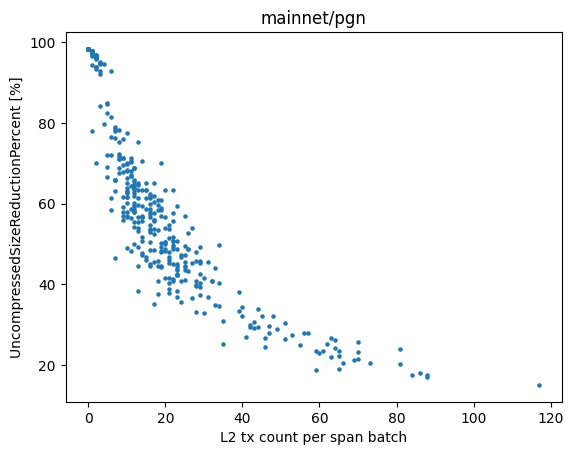

In [12]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_tx_count = result["L2TxCount"]
            Xs.append(l2_tx_count)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 tx count per span batch")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `L2TxCount`: total l2 tx count which is included at span batch / singular batches
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`

Plot:
- X axis: `L2TxCount`
- Y axis: `UncompressedSizeReductionPercent`

Analysis:

If `L2TxCount` is large per span batch, `SpanBatchMetadataSizePercent` will be become less which leads to the reduction of effectiveness of span batch encoding. Therefore relation between `L2TxCount` and `UncompressedSizeReductionPercent` is inversely proportional, which is shown in the plot.

## `L2TxCount - CompressedReductionPercent` Plot

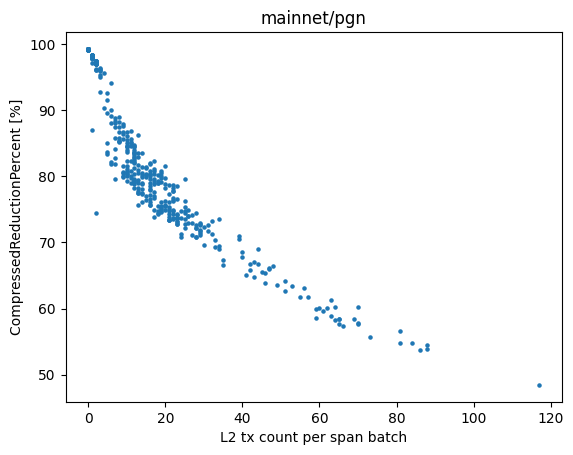

In [13]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_tx_count = result["L2TxCount"]
            Xs.append(l2_tx_count)
            compressed_reduction_precent = result["CompressedReductionPercent"]
            Ys.append(compressed_reduction_precent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 tx count per span batch")
plt.ylabel("CompressedReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `L2TxCount`: total l2 tx count which is included at span batch / singular batches
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`

Plot:
- X axis: `L2TxCount`
- Y axis: `CompressedReductionPercent`

Analysis:

If `L2TxCount` is large per span batch, `SpanBatchMetadataSizePercent` will be become less which leads to the reduction of effectiveness of span batch encoding. Therefore relation between `L2TxCount` and `CompressedReductionPercent` is inversely proportional, which is shown in the plot.

By comparing the results with `L2TxCount - UncompressedSizeReductionPercent` Plot, the plot is shifted upwards. This means reduction percentage is better when compression, leading that span batch encoding is more compression friendly. The direct comparison for the effectiveness of compression will be shown at `L2StartNum - (BatchV1sCompressionRatio, SpanBatchCompressionRatio)` Plot.

## `BatchV1sUncompressedSize - UncompressedSizeReductionPercent` Plot

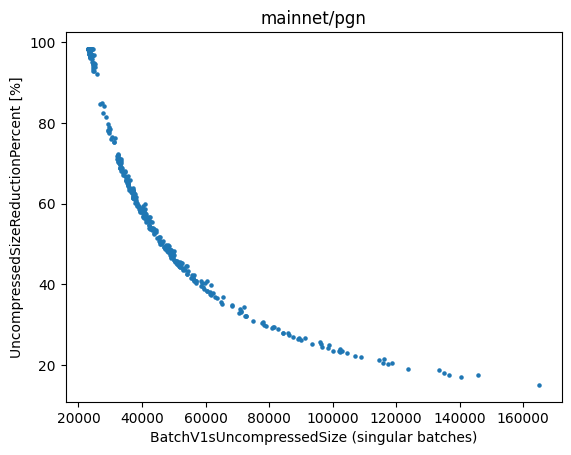

In [14]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            batch_v1s_uncompressed_size = result["BatchV1sUncompressedSize"]
            Xs.append(batch_v1s_uncompressed_size)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)


plt.scatter(Xs, Ys, s=5)
plt.xlabel("BatchV1sUncompressedSize (singular batches)")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`
- `txs`: size of encoded L2 transactions.

Plot:
- X axis: `BatchV1sUncompressedSize`
- Y axis: `UncompressedSizeReductionPercent`

Analysis:

If `BatchV1sUncompressedSize` is large, it means it has larger `txs` size, which leads to the reduction of effectiveness. Therefore relation between `BatchV1sUncompressedSize` and `UncompressedSizeReductionPercent` is inversely proportional, which is shown in the plot.

## `BatchV1sCompressedSize - CompressedReductionPercent` Plot

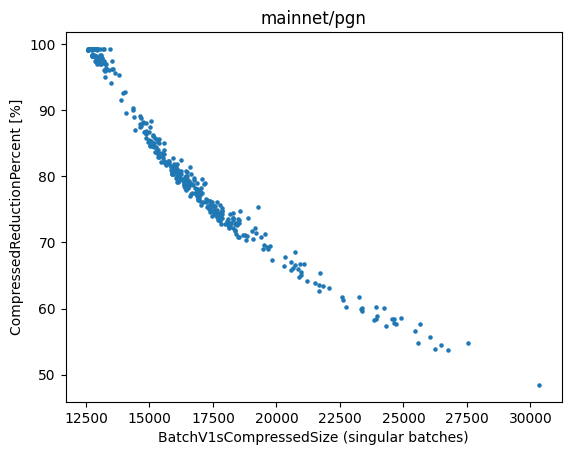

In [15]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            batch_v1s_uncompressed_size = result["BatchV1sCompressedSize"]
            Xs.append(batch_v1s_uncompressed_size)
            compressed_reduction_precent = result["CompressedReductionPercent"]
            Ys.append(compressed_reduction_precent)


plt.scatter(Xs, Ys, s=5)
plt.xlabel("BatchV1sCompressedSize (singular batches)")
plt.ylabel("CompressedReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`
- `txs`: size of encoded L2 transactions.

Plot:
- X axis: `BatchV1sCompressedSize`
- Y axis: `CompressedReductionPercent`

Analysis:

If `BatchV1sCompressedSize` is large, it means it has larger `txs` size, which leads to the reduction of effectiveness. Therefore relation between `BatchV1sCompressedSize` and `CompressedReductionPercent` is inversely proportional, which is shown in the plot.

## `L2StartNum - (BatchV1sCompressionRatio, SpanBatchCompressionRatio)` Plot

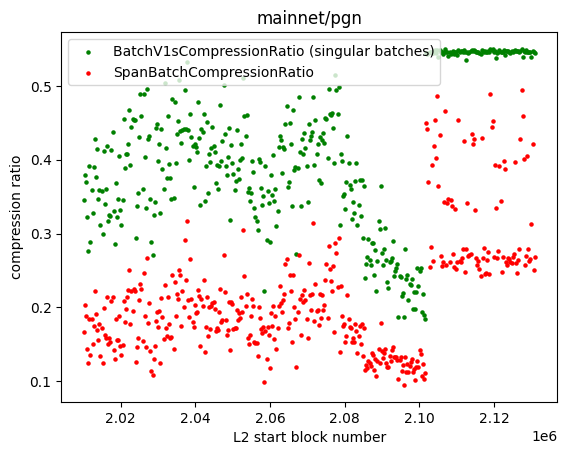

In [16]:
Xs = []
Ys = []
Zs = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            batchv1s_compression_ratio = result["BatchV1sCompressionRatio"]
            Ys.append(batchv1s_compression_ratio)
            spanbatch_compression_ratio = result["SpanBatchCompressionRatio"]
            Zs.append(spanbatch_compression_ratio)


batchv1s_handle = plt.scatter(Xs, Ys, s=5, label="BatchV1sCompressionRatio (singular batches)", c="green")
spanbatch_handle = plt.scatter(Xs, Zs, s=5, label="SpanBatchCompressionRatio", c="red")
plt.xlabel("L2 start block number")
plt.ylabel("compression ratio")
plt.legend(handles=[batchv1s_handle, spanbatch_handle])
plt.title(CHAIN_NAME)
plt.show()


Definition:
- `L2StartNum`: smallest l2 block number which is included at span batch / singular batches
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `BatchV1sCompressionRatio`: `BatchV1sCompressedSize / BatchV1sUncompressedSize`
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `SpanBatchCompressionRatio`: `SpanBatchCompressedSize / SpanBatchUncompressedSize`

Plot:
- X axis: `L2StartNum`
- Y axis: Ratio: (`BatchV1sCompressionRatio`, `SpanBatchCompressionRatio`)

Analysis:

If compression ratio is less, it means input data is more compression friendly. The scatter plot shows a tendency that `SpanBatchCompressionRatio` is less than `BatchV1sCompressionRatio`. Therefore span batch encoding generates data which is more compression friendly.

## Tx Data Encoding Comparsion

Sample single channel and observe span batch results. We compare three tx data encoding schemes.

Each tx data encoding is implemented at https://github.com/testinprod-io/optimism/pull/8. Briefly explaining each tx data encoding schemes:
- V1: Initial transaction encoding design by protolambda: https://github.com/ethereum-optimism/optimism/pull/6077
- V2: Transactions are fully encoded without field separation. This enlarges `SpanBatchUncompressedSize` and reduces effect of span batch.
- V3: Final transaction encoding. This scheme is expected to minimize `SpanBatchUncompressedSize` and also `SpanBatchCompressedSize`.


In [17]:
def sample():
    channel_id = random.choice(list(channel_ids))
    results = []
    for dir in RESULT_DIRS:
        filename = f"{dir}/{channel_id}.json"
        with open(filename) as f:
            result = json.load(f)
            results.append(result)
    return channel_id, results

channel_id, results = sample()
print(f"{channel_id = }")
for result in results:
    print(result)

channel_id = '98f45bf54a61beca6d89b524e8d1bf40'
{'FrameCount': 1, 'BatchV1sCompressedSize': 19483, 'BatchV1sUncompressedSize': 58865, 'BatchV1sCompressionRatio': 0.33097766074917184, 'SpanBatchCompressedSize': 6097, 'SpanBatchUncompressedSize': 35316, 'SpanBatchCompressionRatio': 0.17264129572998074, 'BatchV1sMetadataSize': 23853, 'BatchV1sTxSize': 35012, 'SpanBatchMetadataSize': 388, 'SpanBatchTxSize': 34928, 'SpanBatchPrefixSize': 48, 'SpanBatchPayloadSize': 35268, 'CompressedReductionPercent': 68.70605142945132, 'UncompressedSizeReductionPercent': 40.00509640703305, 'L2TxCount': 34, 'L1StartNum': 18013559, 'L1EndNum': 18013608, 'L1BlockCount': 50, 'L2StartNum': 2062041, 'L2EndNum': 2062340, 'L2BlockCount': 300}
{'FrameCount': 1, 'BatchV1sCompressedSize': 19483, 'BatchV1sUncompressedSize': 58865, 'BatchV1sCompressionRatio': 0.33097766074917184, 'SpanBatchCompressedSize': 6210, 'SpanBatchUncompressedSize': 35489, 'SpanBatchCompressionRatio': 0.17498379779650033, 'BatchV1sMetadataSize'

## Tx Data Encoding Comparison before Compression


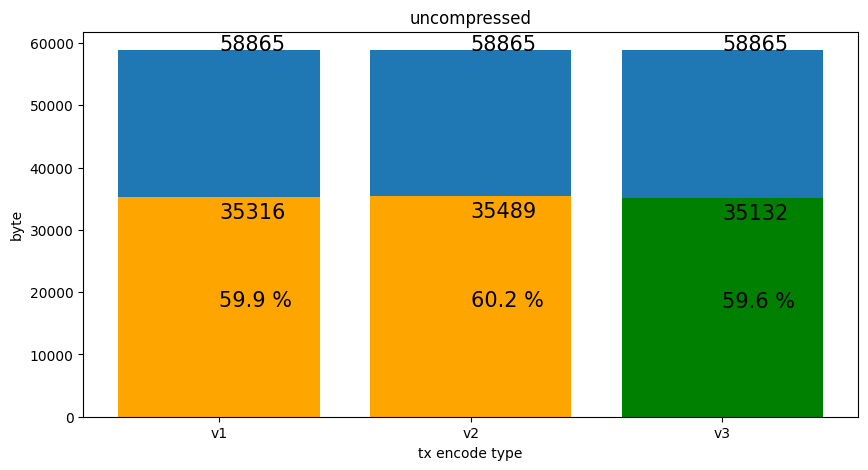

In [18]:
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sUncompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchUncompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["UncompressedSizeReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value * 0.9, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("uncompressed")
plt.show()


Definition:
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`

Plot:
- X axis: tx data encoding type. Varies in v1, v2, v3
- Y axis: byte size

Analysis:

Below bar graph shows the effectiveness of three tx data encoding schemes before compression. Each bar indicates original `BatchV1sUncompressedSize`, which must be equal for three tx data encoding schemes because the schemes are for span batches. Each bar also indicates `SpanBatchUncompressedSize` which each tx encoding scheme is applied. We can observe that version 3 shows the most size reduction.

## Tx Data Encoding Comparison after Compression


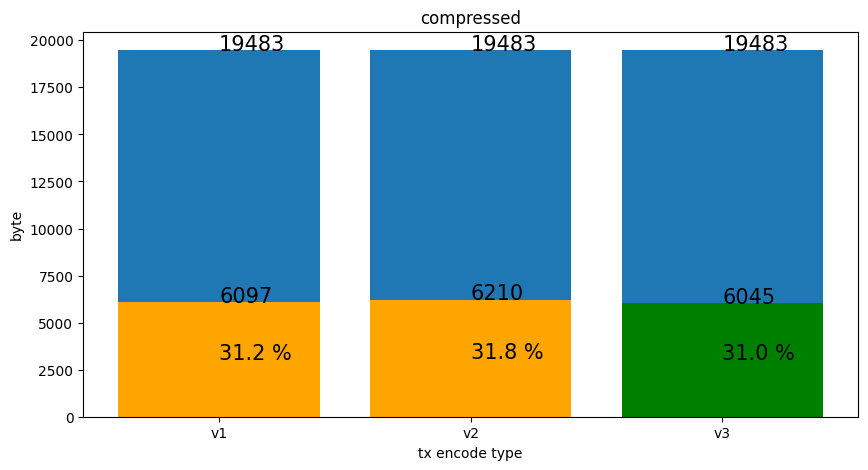

In [19]:
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sCompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchCompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["CompressedReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("compressed")
plt.show()

Definition:
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`

Plot:
- X axis: tx data encoding type. Varies in v1, v2, v3
- Y axis: byte size

Analysis:

Below bar graph shows the effectiveness of three tx data encoding schemes after compression. Each bar indicates original `BatchV1sCompressedSize`, which must be equal for three tx data encoding schemes because the schemes are for span batches. Each bar also indicates `SpanBatchCompressedSize` which each tx encoding scheme is applied. We can observe that version 3 shows the most size reduction.


# Span Batch Analysis - L2 Block Accumulation

## Span Batch Analysis - L2 Block Accumulation without Compression

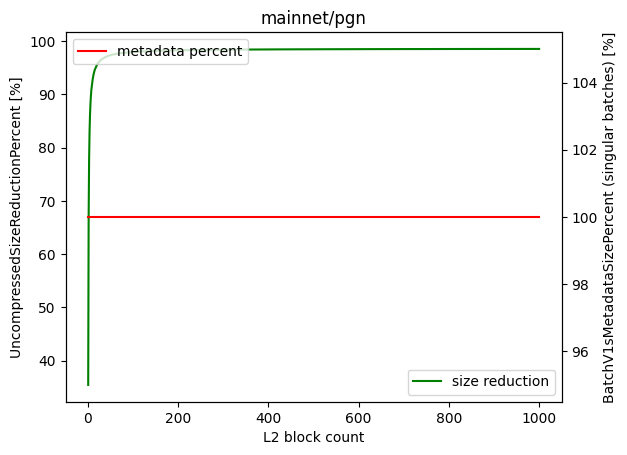

In [20]:
FILENAME = f"{DATA_DIR}/merge_result/{ACC_L2_START_NUM}_{ACC_L2_END_NUM}.json"
CLAMP = 0

Xs, Ys, Zs = [], [], []
with open(FILENAME) as f:
    result = json.load(f)["Result"]
    for i in range(CLAMP, ACC_L2_END_NUM - ACC_L2_START_NUM):
        # check L2EndNum is sane
        assert result[i]["L2EndNum"] == ACC_L2_START_NUM + i
        
        l2_block_count = result[i]["L2BlockCount"]
        Xs.append(l2_block_count)
        uncompressed_reduction_precent = result[i]["UncompressedSizeReductionPercent"]
        Ys.append(uncompressed_reduction_precent)
        tx_size = result[i]["BatchV1sTxSize"]
        metadata_size = result[i]["BatchV1sMetadataSize"]
        metadata_percent = metadata_size / (metadata_size + tx_size) * 100
        Zs.append(metadata_percent)
        

fig, ax1 = plt.subplots()
ax1.plot(Xs, Ys, label="size reduction", c="green")
ax2 = ax1.twinx()
ax2.plot(Xs, Zs, label="metadata percent", c="red")
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_xlabel("L2 block count")
ax1.set_ylabel("UncompressedSizeReductionPercent [%]")
ax2.set_ylabel("BatchV1sMetadataSizePercent (singular batches) [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `L2BlockCount`: total l2 block count which is included at span batch
- `SpanBatchUncompressedSize`: size of encoded span batch. Not compressed yet.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `UncompressedSizeReductionPercent`: `100 * SpanBatchUncompressedSize / BatchV1sUncompressedSize`
- `BatchV1sMetadataSize`: size of encoded singular batches except `txs` field.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `BatchV1sMetadataSizePercent`: `100 * BatchV1sMetadataSize / BatchV1sUncompressedSize`

Plot:
- X axis: `L2BlockCount`
- Y axis: (`UncompressedSizeReductionPercent`, `BatchV1sMetadataSizePercent`)

Analysis:

The property that `UncompressedSizeReductionPercent` and `BatchV1sMetadataSizePercent` are proportional is conserved when L2 block count per span batch increases.

## Span Batch Analysis - L2 Block Accumulation with Compression

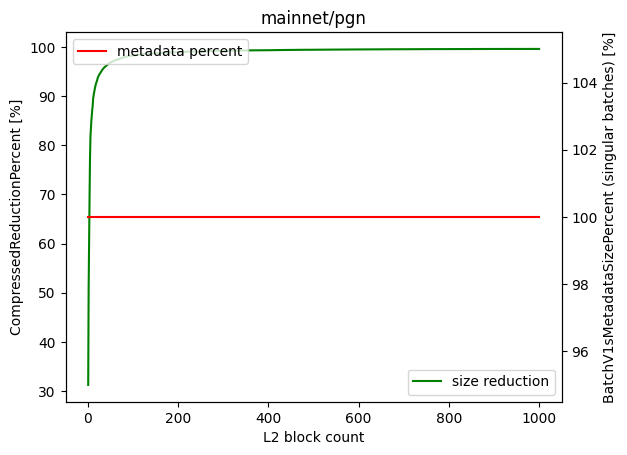

In [21]:
FILENAME = f"{DATA_DIR}/merge_result/{ACC_L2_START_NUM}_{ACC_L2_END_NUM}.json"
CLAMP = 0

Xs, Ys, Zs = [], [], []
with open(FILENAME) as f:
    result = json.load(f)["Result"]
    for i in range(CLAMP, ACC_L2_END_NUM - ACC_L2_START_NUM):
        # check L2EndNum is sane
        assert result[i]["L2EndNum"] == ACC_L2_START_NUM + i
        
        l2_block_count = result[i]["L2BlockCount"]
        Xs.append(l2_block_count)
        uncompressed_reduction_precent = result[i]["CompressedReductionPercent"]
        Ys.append(uncompressed_reduction_precent)
        tx_size = result[i]["BatchV1sTxSize"]
        metadata_size = result[i]["BatchV1sMetadataSize"]
        metadata_percent = metadata_size / (metadata_size + tx_size) * 100
        Zs.append(metadata_percent)
        

fig, ax1 = plt.subplots()
ax1.plot(Xs, Ys, label="size reduction", c="green")
ax2 = ax1.twinx()
ax2.plot(Xs, Zs, label="metadata percent", c="red")
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_xlabel("L2 block count")
ax1.set_ylabel("CompressedReductionPercent [%]")
ax2.set_ylabel("BatchV1sMetadataSizePercent (singular batches) [%]")
plt.title(CHAIN_NAME)
plt.show()

Definition:
- `L2BlockCount`: total l2 block count which is included at span batch
- `SpanBatchCompressedSize`: size of encoded span batch after compression.
- `BatchV1sCompressedSize`: size of encoded singular batches after compression.
- `CompressedReductionPercent`: `100 * SpanBatchCompressedSize / BatchV1sCompressedSize`
- `BatchV1sMetadataSize`: size of encoded singular batches except `txs` field.
- `BatchV1sUncompressedSize`: size of encoded singular batches. Not compressed yet.
- `BatchV1sMetadataSizePercent`: `100 * BatchV1sMetadataSize / BatchV1sUncompressedSize`

Plot:
- X axis: `L2BlockCount`
- Y axis: Percentage: (`CompressedReductionPercent`, `BatchV1sMetadataSizePercent`)

Analysis:

The property that `CompressedReductionPercent` and `BatchV1sMetadataSizePercent` are proportional is conserved when L2 block count per span batch increases.